## Pre-processing Text

This notebook takes raw climber's logs from https://summitpost.org and pre-processes the text so that we can use it for EDA and modeling.

In [1]:
import nltk
import pandas as pd
import numpy as np

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

In [2]:
# Load in the data into a dataframe and change data types 

data = pd.read_csv('climber_logs.csv')
data['comment_date'] = pd.to_datetime(data['comment_date'])
data['climb_date'] = pd.to_datetime(data['climb_date'])
data['comment'] = data['comment'].replace(np.nan, '', regex=True)

print(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67639 entries, 0 to 67638
Data columns (total 4 columns):
mountain        67639 non-null object
comment         67639 non-null object
comment_date    67632 non-null datetime64[ns]
climb_date      44534 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 2.1+ MB
None


,mountain,comment,comment_date,climb_date
0,Mount Whitney,Did this in a single day... very difficult for...,2018-11-19 08:51:00,2015-09-05
1,Mount Whitney,Mountaineers Route - first 14er,2018-11-01 06:34:00,NaT
2,Mount Whitney,Standard route from Whitney Portal via Trail C...,2018-10-01 12:44:00,2018-10-27
3,Mount Whitney,Worth hiking the 220-something miles along the...,2018-09-10 10:23:00,2016-07-23
4,Mount Whitney,"My brother John, his son and I backpacked in t...",2018-08-15 02:28:00,2018-08-10
5,Mount Whitney,Words will never describe the breathtaking vie...,2018-08-02 11:50:00,2018-07-01
6,Mount Whitney,Portal out and back,2018-07-31 07:51:00,2018-07-29
7,Mount Whitney,Great 2am ascent from Trail Camp.\nhttps://the...,2018-07-28 20:09:00,2018-07-28
8,Mount Whitney,Hiked from guitar lake in the middle of the ni...,2018-07-24 06:33:00,2014-08-08
9,Mount Whitney,Summited Whitney via the Whitney Trail with tw...,2018-07-02 07:31:00,2018-06-24


In [3]:
# Preprocess text - change to lowercase, remove numbers, punctuation, and line breaks

import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
no_new_line = lambda x: re.sub('\n', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

data['comment'] = data.comment.map(alphanumeric).map(punc_lower).map(no_new_line)
data.head()

,mountain,comment,comment_date,climb_date
0,Mount Whitney,did this in a single day very difficult for a ...,2018-11-19 08:51:00,2015-09-05
1,Mount Whitney,mountaineers route first,2018-11-01 06:34:00,NaT
2,Mount Whitney,standard route from whitney portal via trail c...,2018-10-01 12:44:00,2018-10-27
3,Mount Whitney,worth hiking the something miles along the joh...,2018-09-10 10:23:00,2016-07-23
4,Mount Whitney,my brother john his son and i backpacked in to...,2018-08-15 02:28:00,2018-08-10


In [5]:
# Exporting as CSV to create a MongoDB

data.to_csv("cleaned_corpus.csv")

In [4]:
# Pickling for later use

data.to_pickle("cleaned_corpus.pkl")

I have each comment for each mountain in its own row.  Let's combine all the comments for each mountain into one large chunk of text.

In [4]:
# how many climber logs are there for each mountain?
# there are only 931 mountains out of the original 960 scraped because there are some without any climber logs

grouped = data.groupby('mountain')['comment'].nunique()
grouped

mountain
"Owl's Head Mountain" (Peak above Owl's Head)     17
Abajo Peak                                        15
Abercrombie Mountain                              22
Aconcagua                                        216
Adams, Mount                                      45
Agassiz Peak                                      31
Agung                                             13
Aiguille Dibona                                   17
Aiguille Verte                                    18
Aiguille d'Argentière                             26
Aiguille de Rochefort                             15
Aiguille du Midi                                 104
Aiguille du Tour                                  59
Aiguilles du Dru (or Les Drus)                    11
Alam Kooh                                          7
Alberta, Mount                                     1
Aletschhorn                                       15
Algonquin Peak                                   158
Allalinhorn                          

Wait, there are mountains with only a few logs. Spot checking them, they appear to either be the most dangerous and difficult to get to, or just are not very popular, despite the number of page "hits".


In [5]:
less_logs = data[data.groupby('mountain')['comment'].transform('nunique') <= 5].groupby('mountain')['comment'].nunique()

print(len(less_logs))
less_logs


70


mountain
Alberta, Mount                                                                                                                1
Annapurna I                                                                                                                   2
Badger Mountain                                                                                                               4
Beartooth Mountain                                                                                                            3
Belknap Mountain                                                                                                              5
Blue Job Mountain                                                                                                             5
Boxcar Rocks (Chinese Wall)                                                                                                   4
Burned hill                                                                                    

Let's remove these from our dataset.

In [6]:
more_logs = data[data.groupby('mountain')['comment'].transform('nunique') > 5]

data_dict = more_logs.groupby('mountain')['comment'].apply(list).to_dict()

In [7]:
# let's look at one entry

data_dict["Anthony's Nose"]

['took a quick look up on anthonys nose while hiking the at saw a few people on top excellent views up and down the hudson',
 'great workout and the views help loads of fun in the wintersnow brings a whole new challenge ',
 'i remember this as being a good workout to climb from the river by the at',
 'this was a great short hike but like other posters have saidstart from the southern end of the trail and wear bug sprayin the summer it gets pretty bad',
 'this is my regular workout hike i usually take the topsecret scramble route ',
 'i specifically hiked the short side trail off the appalachian trail to this spot to get a view of the bear mountain bridge and hudson river',
 'this one isnt too popular but does provide a nice overlook of the hudson',
 'id probably do this hike from the southern end of the trail if i were to do it again from the north you go directly to the summit and the best view of the hike other overlooks arent as good total hiking distance was about  miles']

In [8]:
# combine all the logs into one large block of text

def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

data_combined_dict = {key: [combine_text(value)] for (key, value) in data_dict.items()}

In [9]:
pd.set_option('max_colwidth',150)

data_combined = pd.DataFrame.from_dict(data_combined_dict).transpose()
data_combined.columns = ['comment']
data_combined = data_combined.sort_index()
data_combined

,comment
"""Owl's Head Mountain"" (Peak above Owl's Head)",first climbed to the summit of owls head on october to complete the northeast new england and new hampshire lists of peaks always meant to go...
Abajo Peak,drove almost to the top but was stopped by construction wasnt sure i was going to be able to get there and was afraid of being yelled at but i snu...
Abercrombie Mountain,one of the lamer ultraprominence peaks but at least it was short and easy and the nearby canadian border crossing had the least unfriendly guard i...
Aconcagua,lessened winds and sunny skies along with good use of contingency days for further accclimatization allowed summiting many thanks to the aai guide...
"Adams, Mount",i had toyed with different ways to get mt adams finally settling on a willow lake approach the plan was for a day jaunt getting as many of the pe...
Agassiz Peak,snow hike trip report if someone tells you that your mother in law will stop butting into your business if you said a prayer on agassiz peak its a...
Agung,left the trailhead at am and arrived at highest point at am enjoyed hot chocolate supplied by guide and views of the crater mt batur and other s...
Aiguille Dibona,splendid rock on a perfect day two great routes in two different styles in two days wow extraordinary route and peak highly recommended climbed th...
Aiguille Verte,climbed this route with louis reichardt during three weeks we spent climbing in the chamonix alps we had a very early start to avoid rockfall on t...
Aiguille d'Argentière,exact date uncertain climbed this route with louis reichardt during the three weeks we spent climbing in the chamonix alps from our campsite near ...


In [13]:
# Let's pickle this one too
     
data_combined.to_pickle("combined_corpus.pkl")

## Use Gensim to create bi-grams and tri-grams

In [11]:
import gensim

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

clean_sents = list(sent_to_words(data_combined.comment))

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(clean_sents, min_count=20) # higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[clean_sents], min_count=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the ge

In [13]:
for s in clean_sents[0:5]:
    print(f"{' '.join(trigram_model[bigram_model[s]]) } \n")

first climbed to the summit of owls head on october to complete the northeast new_england and new_hampshire lists of peaks always meant to go_back after the true_summit was relocated by about of mile in but never got around to it other fish to fry as the saying goes but now with just one new_england highest hundred peak remaining to finish that list finally decided to update my credentials and grabbed the new notsonew tippy top on august nice long hike had thought the scrambling was going to be way tougher and longer_than it turned_out the water crossings were heaven sent on the return since it meant chance to soak my feet in the nice cold water didnt_see_single soul_until started back down it took four_hours and ten_minutes from the lincoln_woods parking_lot the river crossings were high and took my shoes and socks off and kept them dry the first_time but after that simply waded in the former army engineer officer met at the top was fun to talk with at the bottom turned right and head

In [14]:
clean_sents = [trigram_model[bigram_model[t]] for t in clean_sents]

In [15]:
for t in clean_sents[:5]:
    print(f"{' '.join(t)} \n")

first climbed to the summit of owls head on october to complete the northeast new_england and new_hampshire lists of peaks always meant to go_back after the true_summit was relocated by about of mile in but never got around to it other fish to fry as the saying goes but now with just one new_england highest hundred peak remaining to finish that list finally decided to update my credentials and grabbed the new notsonew tippy top on august nice long hike had thought the scrambling was going to be way tougher and longer_than it turned_out the water crossings were heaven sent on the return since it meant chance to soak my feet in the nice cold water didnt_see_single soul_until started back down it took four_hours and ten_minutes from the lincoln_woods parking_lot the river crossings were high and took my shoes and socks off and kept them dry the first_time but after that simply waded in the former army engineer officer met at the top was fun to talk with at the bottom turned right and head

## Remove stop words

There are some words like "day", "summit", and "mountain" that are very popular, but don't provide much insight or meaning, so let's add them to a stop words list.

In [16]:
import nltk

# Run below line if not already downloaded 

# nltk.download('stopwords')

In [11]:
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['day','summit','climb','hike','mountain','peak','great','good','time','hour','nice','beautiful',
                   'view','route','trail','ridge','go','way','get','take','start','trip','reach','weather'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [18]:
clean_sents = remove_stopwords(clean_sents)

NameError: name 'clean_sents' is not defined

In [19]:
for t in clean_sents[:5]:
    print(f"{' '.join(t)} \n")

first climbed owls head october complete northeast new_england new_hampshire lists peaks always meant go_back true_summit relocated mile never got around fish fry saying goes one new_england highest hundred peak remaining finish list finally decided update credentials grabbed new notsonew tippy top august nice long hike thought scrambling going way tougher longer_than turned_out water crossings heaven sent return since meant chance soak feet nice cold water soul_until started back took four_hours ten_minutes lincoln_woods parking_lot river crossings high took shoes socks kept dry first_time simply waded former army engineer officer met top fun talk bottom turned right headed uphill top mount garfield second last nineteen mile cold bit slow time got galehead hut dark hiked about_hours starting lincoln_woods about_am late_start blamed adapting mountain daylight time about_mile realized_that started wrong east_side pemigawasset rivers east branch east_side trail mistake cross river carefu

## Use spaCy to Lemmatize 

In [20]:
import spacy

In [21]:
nlp = spacy.load('en', disable=['parser', 'ner'])

# NOUN, ADJ, VERB, ADV
def lemmatization(texts, allowed_postags=['NOUN','ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        
        output_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_stop == False]
        
        if len(output_text) > 0:
            texts_out.append(output_text)
    return texts_out

In [22]:
clean_sents = lemmatization(clean_sents)

In [23]:
for t in clean_sents[0:5]:
    print(f"{' '.join(t)} \n")

climb owl head october complete northeast new_england new_hampshire list peak mean go_back true_summit relocate mile get fish fry saying go new_england high peak remain finish list finally decide update credential grab new notsonew tippy august nice long hike thought scramble go way tough longer_than turned_out water crossing send return mean chance soak foot nice cold water soul_until start take four_hour ten_minute lincoln_wood parking_lot river crossing high take shoe sock keep dry first_time simply wad army engineer officer meet fun talk turn right head uphill garfield second mile cold bit slow time get galehead hut dark hike about_hour start lincoln_wood about_am late_start blame adapt mountain daylight time realized_that start wrong east_side pemigawasset river east branch east_side trail mistake cross river carefully fall log lincoln_wood traili see no_one_else after_leav franconia brook_trail pmi good time owl head spur path last_mile kicked_my_butt feel little overconfident co

In [24]:
clean_sents[0]

['climb',
 'owl',
 'head',
 'october',
 'complete',
 'northeast',
 'new_england',
 'new_hampshire',
 'list',
 'peak',
 'mean',
 'go_back',
 'true_summit',
 'relocate',
 'mile',
 'get',
 'fish',
 'fry',
 'saying',
 'go',
 'new_england',
 'high',
 'peak',
 'remain',
 'finish',
 'list',
 'finally',
 'decide',
 'update',
 'credential',
 'grab',
 'new',
 'notsonew',
 'tippy',
 'august',
 'nice',
 'long',
 'hike',
 'thought',
 'scramble',
 'go',
 'way',
 'tough',
 'longer_than',
 'turned_out',
 'water',
 'crossing',
 'send',
 'return',
 'mean',
 'chance',
 'soak',
 'foot',
 'nice',
 'cold',
 'water',
 'soul_until',
 'start',
 'take',
 'four_hour',
 'ten_minute',
 'lincoln_wood',
 'parking_lot',
 'river',
 'crossing',
 'high',
 'take',
 'shoe',
 'sock',
 'keep',
 'dry',
 'first_time',
 'simply',
 'wad',
 'army',
 'engineer',
 'officer',
 'meet',
 'fun',
 'talk',
 'turn',
 'right',
 'head',
 'uphill',
 'garfield',
 'second',
 'mile',
 'cold',
 'bit',
 'slow',
 'time',
 'get',
 'galehead',
 'hu

In [25]:
# Pickling the n-grammed and lemmatized text with stop words removed

pickle.dump(clean_sents, open("clean_sents.pkl", "wb"))

## Find Top Words with Count Vectorizer

In [12]:
# First make a document term matrix

cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_combined.comment)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_combined.index

data_dtm.to_pickle("dtm_combined.pkl")

data_dtm.head(10)

,aa,aaa,aaaaargh,aaaalllllll,aaaargh,aaahhhh,aac,aahead,aai,aais,...,šerbota,škoda,špicek,štrbské,štít,žabljak,žlab,倉岡,千恵,裕之
"""Owl's Head Mountain"" (Peak above Owl's Head)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abajo Peak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abercrombie Mountain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aconcagua,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
"Adams, Mount",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agassiz Peak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agung,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aiguille Dibona,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aiguille Verte,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aiguille d'Argentière,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
data_dtm = data_dtm.transpose()

In [14]:
top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending=False).head(30)
    top_dict[c] = list(zip(top.index, top.values))

top_dict

{'"Owl\'s Head Mountain" (Peak above Owl\'s Head)': [('back', 10),
  ('slide', 8),
  ('found', 7),
  ('mile', 7),
  ('head', 7),
  ('owls', 7),
  ('one', 6),
  ('made', 6),
  ('lincoln', 6),
  ('crossings', 6),
  ('true', 6),
  ('woods', 5),
  ('new', 5),
  ('first', 5),
  ('top', 5),
  ('cairn', 4),
  ('dont', 4),
  ('didnt', 4),
  ('little', 4),
  ('took', 4),
  ('bad', 4),
  ('around', 4),
  ('water', 4),
  ('got', 4),
  ('galehead', 3),
  ('last', 3),
  ('remember', 3),
  ('actually', 3),
  ('two', 3),
  ('going', 3)],
 'Abajo Peak': [('road', 14),
  ('pass', 6),
  ('views', 6),
  ('top', 5),
  ('monticello', 5),
  ('hiked', 5),
  ('drove', 5),
  ('north', 5),
  ('snow', 4),
  ('creek', 4),
  ('back', 4),
  ('took', 4),
  ('utah', 3),
  ('drive', 3),
  ('old', 3),
  ('west', 3),
  ('going', 3),
  ('one', 3),
  ('near', 3),
  ('saw', 2),
  ('south', 2),
  ('stopped', 2),
  ('steep', 2),
  ('radio', 2),
  ('la', 2),
  ('jackson', 2),
  ('several', 2),
  ('brother', 2),
  ('ascent', 2

In [15]:
for mountain, top_words in top_dict.items():
    print(mountain)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

"Owl's Head Mountain" (Peak above Owl's Head)
back, slide, found, mile, head, owls, one, made, lincoln, crossings, true, woods, new, first
---
Abajo Peak
road, pass, views, top, monticello, hiked, drove, north, snow, creek, back, took, utah, drive
---
Abercrombie Mountain
views, road, well, abercrombie, shape, area, trailhead, didnt, saw, going, made, cool, one, north
---
Aconcagua
camp, days, de, snow, polish, nido, plaza, back, made, high, climbed, hours, normal, via
---
Adams, Mount
adams, lake, willow, climbed, creek, horn, made, south, un, crestone, views, back, fun, peaks
---
Agassiz Peak
agassiz, humphreys, snow, ski, climbed, top, would, one, back, early, saddle, left, took, avalanche
---
Agung
started, around, sunrise, back, crater, steep, guide, pura, rim, make, top, besakih, motorcycle, left
---
Aiguille Dibona
us, hut, via, top, days, sun, rock, two, dibona, climbed, voie, first, hours, perfect
---
Aiguille Verte
couloir, whymper, climbed, verte, conditions, rocheuse, final

Thompson Peak
lake, south, thompson, climbed, views, little, back, area, one, north, got, first, long, creek
---
Three Fingered Jack
crawl, one, rock, group, made, us, climbed, top, exposure, back, climbing, snow, rope, chimney
---
Three Fingers
lookout, one, snow, night, gap, hours, back, miles, glacier, ice, views, left, goat, first
---
Thunderbolt Peak
block, climbed, traverse, chute, couloir, rope, back, thunderbolt, top, climbing, class, fun, south, starlight
---
Tikaboo Peak
area, tikaboo, top, car, really, badger, saw, covered, base, road, bag, negotiate, lvmc, also
---
Timms Hill
tower, hill, highpoint, climbed, views, road, state, park, area, top, hp, first, little, trees
---
Tochal
climbed, snow, shirpala, first, night, visible, covered, without, tehran, second, air, acclimatization, velenjak, chal
---
Tocllaraju
camp, snow, bergschrund, made, high, two, around, de, conditions, short, pitch, section, fun, la
---
Tofana di Rozes
ferrata, via, lipella, long, rif, dibona, fantas

In [16]:
# Create a list of mountain names

mountains = []

for mountain in top_dict.keys():
    mountains.append(mountain)
    
print(len(mountains))
mountains

861


['"Owl\'s Head Mountain" (Peak above Owl\'s Head)',
 'Abajo Peak',
 'Abercrombie Mountain',
 'Aconcagua',
 'Adams, Mount',
 'Agassiz Peak',
 'Agung',
 'Aiguille Dibona',
 'Aiguille Verte',
 "Aiguille d'Argentière",
 'Aiguille de Rochefort',
 'Aiguille du Midi',
 'Aiguille du Tour',
 'Aiguilles du Dru (or Les Drus)',
 'Alam Kooh',
 'Aletschhorn',
 'Algonquin Peak',
 'Allalinhorn',
 'Allen Mountain',
 'Almagre Mountain',
 'Alpamayo',
 'Alphubel',
 'Alta Peak',
 'Ama Dablam',
 'American Fork Twin Peaks',
 'Aneto',
 'Angels Landing',
 'Annapolis Rocks',
 "Anthony's Nose",
 'Aoraki - Cook',
 'Apache Peak',
 'Aragats (Арагац)',
 'Ararat',
 'Arc Dome',
 'Arrow Peak',
 'Artesonraju',
 'Assiniboine',
 'Avalanche Peak',
 'Baboquivari Peak',
 'Backbone Mountain',
 'Baden-Powell',
 'Bald Mountain',
 'Baldy Mountain (NM)',
 'Banner Peak',
 'Baring Mountain',
 'Barre des Ecrins',
 'Basin Mountain',
 'Bear Creek Spire',
 'Bear Mountain',
 'Bear Peak',
 'Bearfence Mountain',
 'Ben Lomond',
 'Ben Nevis

In [17]:
# Let's make some pretty word clouds!
# If not installed: conda install -c conda-forge wordcloud

from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color='white', colormap='Dark2', 
               max_font_size=150, random_state=10)

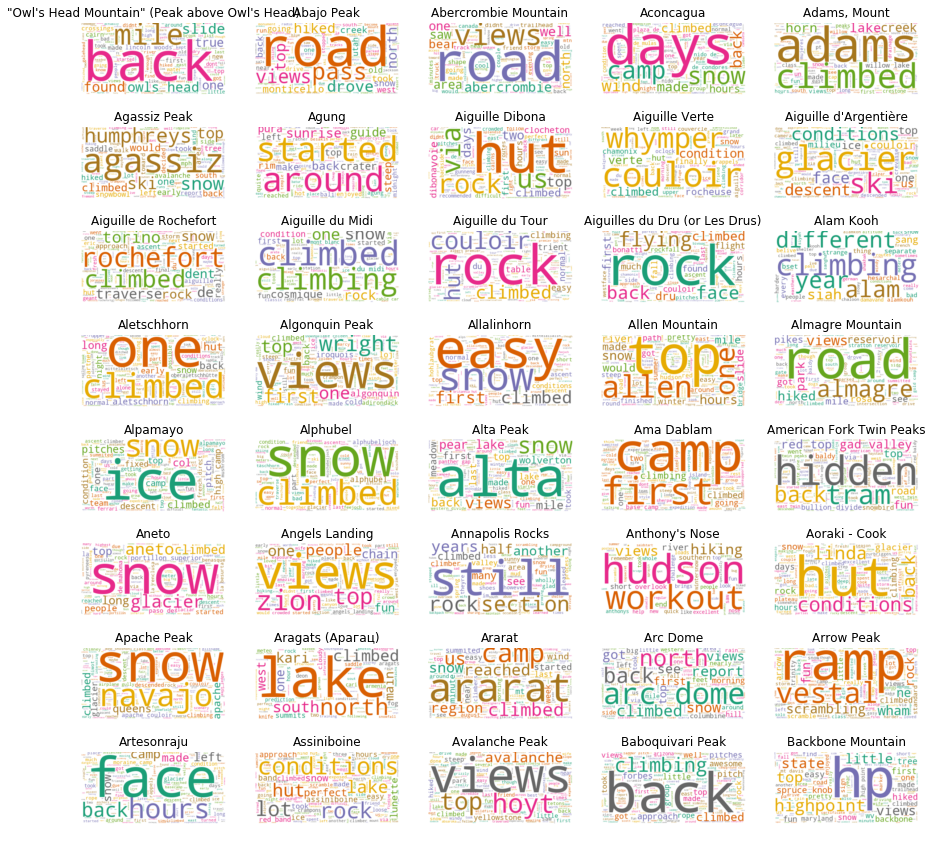

In [18]:
plt.rcParams['figure.figsize'] = [15,15]

for index, mountain in enumerate(data_dtm.columns[:40]):
    wc.generate(data_combined.comment[mountain])

    plt.subplot(8, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(mountains[index])
    
plt.show()

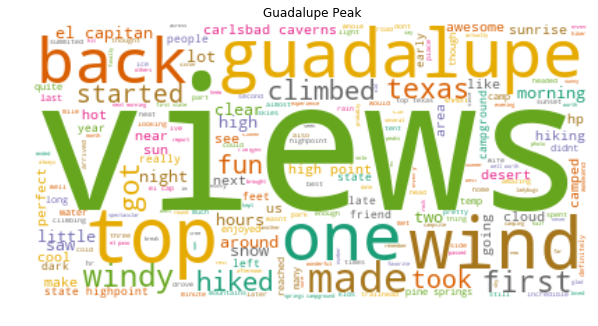

In [35]:
# create word clouds for specific mountains

plt.rcParams['figure.figsize'] = [10,6]

wc.generate(data_combined.comment['Guadalupe Peak'])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Guadalupe Peak')
    
plt.show()

In [ ]:
'''
testing different topic modeling below, none of it used in prod
'''

## testing LSA topic modeling

In [59]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
doc_word = vectorizer.fit_transform(data_combined.comment)
doc_word.shape

(861, 57388)

In [60]:
pd.DataFrame(doc_word.toarray(), index=data_combined.index.values, columns=vectorizer.get_feature_names()).head(10)

,aa,aaa,aaaaargh,aaaalllllll,aaaargh,aaahhhh,aac,aahead,aai,aais,...,šerbota,škoda,špicek,štrbské,štít,žabljak,žlab,倉岡,千恵,裕之
"""Owl's Head Mountain"" (Peak above Owl's Head)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abajo Peak,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abercrombie Mountain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aconcagua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01202,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Adams, Mount",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agassiz Peak,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiguille Dibona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiguille Verte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiguille d'Argentière,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
lsa = TruncatedSVD(3) # getting N most important components/topics
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.01321836, 0.02013618, 0.01097567])

In [69]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaaargh,aaaalllllll,aaaargh,aaahhhh,aac,aahead,aai,aais,...,šerbota,škoda,špicek,štrbské,štít,žabljak,žlab,倉岡,千恵,裕之
component_1,0.003,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.002,0.000,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
component_2,-0.008,0.002,-0.0,-0.0,-0.0,0.0,-0.001,-0.0,-0.003,-0.001,...,-0.0,0.0,-0.0,-0.000,-0.0,0.000,-0.001,-0.001,-0.001,-0.001
component_3,0.006,0.003,-0.0,0.0,0.0,0.0,-0.001,0.0,0.002,0.000,...,0.0,0.0,0.0,0.001,0.0,0.001,0.001,0.001,0.001,0.001


In [70]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [71]:
display_topics(lsa, vectorizer.get_feature_names(), 5)


Topic  0
great, trail, hike, snow, route

Topic  1
trail, hike, views, road, highpoint

Topic  2
hut, highpoint, hp, weather, glacier


In [51]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = data_combined.index.values,
             columns = ["component_1","component_2","component_3"])
Vt

,component_1,component_2,component_3
"""Owl's Head Mountain"" (Peak above Owl's Head)",0.27830,0.12096,0.01328
Abajo Peak,0.25694,0.11208,-0.01812
Abercrombie Mountain,0.35959,0.20794,0.01382
Aconcagua,0.31775,-0.12938,0.18649
"Adams, Mount",0.31975,-0.06112,-0.15706
Agassiz Peak,0.24962,0.00951,-0.01042
Agung,0.20952,-0.00981,0.08550
Aiguille Dibona,0.22811,-0.13487,0.10150
Aiguille Verte,0.18214,-0.15892,0.10971
Aiguille d'Argentière,0.28488,-0.24360,0.17042


## testing NMF topic modeling

In [72]:
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(doc_word)

In [73]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaaargh,aaaalllllll,aaaargh,aaahhhh,aac,aahead,aai,aais,...,šerbota,škoda,špicek,štrbské,štít,žabljak,žlab,倉岡,千恵,裕之
component_1,0.004,0.000,0.001,0.0,0.0,0.000,0.003,0.0,0.005,0.001,...,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
component_2,0.000,0.002,0.000,0.0,0.0,0.001,0.000,0.0,0.000,0.000,...,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
component_3,0.015,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.005,0.001,...,0.0,0.0,0.001,0.001,0.0,0.001,0.002,0.002,0.002,0.002


In [74]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
route, ridge, lake, climb, class, great, fun, climbed, snow, rock

Topic  1
trail, hike, views, great, nice, peak, road, way, mountain, hiked

Topic  2
hut, route, climb, glacier, snow, weather, camp, climbed, conditions, great


In [75]:
H = pd.DataFrame(doc_topic.round(5),
             index = data_combined.index.values,
             columns = ["component_1","component_2","component_3"])
H

,component_1,component_2,component_3
"""Owl's Head Mountain"" (Peak above Owl's Head)",0.01093,0.12679,0.00998
Abajo Peak,0.02453,0.10979,0.00000
Abercrombie Mountain,0.00000,0.18780,0.00000
Aconcagua,0.00000,0.02247,0.22256
"Adams, Mount",0.12909,0.03259,0.00000
Agassiz Peak,0.04064,0.06544,0.03177
Agung,0.00000,0.04940,0.09188
Aiguille Dibona,0.03392,0.00004,0.13040
Aiguille Verte,0.01502,0.00000,0.13916
Aiguille d'Argentière,0.01575,0.00000,0.22715
